## SkyScan Audit - Airplane Classifier

Detect passenger jets from SkyScan images

In [27]:
################################################
##
## Object Detection
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report


#######################################################

from fastai.vision.all import *


#######################################################

N_EPOCHS = 10000          ## 4000
batch_size = 10   ## 5    ## 32
learning_rate =  0.1    ## 0.01   ## 1e-5 


#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################

## Load SkyScanCorpus

In [10]:

## Download SkyScanCorpus with a folder inside for each class (e.g. boeing, airbus, etc). 
## Put images in each corresponding folder

path = Path('CorpusSkyScan')


In [11]:
fns = get_image_files(path)
fns

(#11093) [Path('CorpusSkyScan/GATES/A34517_2021-03-30-17-31-36.jpg'),Path('CorpusSkyScan/GATES/A34517_2021-03-30-17-31-34.jpg'),Path('CorpusSkyScan/GATES/A34517_2021-03-30-17-31-35.jpg'),Path('CorpusSkyScan/GATES/A34517_2021-03-30-17-31-54.jpg'),Path('CorpusSkyScan/GATES/A34517_2021-03-30-17-32-05.jpg'),Path('CorpusSkyScan/GATES/A34517_2021-03-30-17-32-11.jpg'),Path('CorpusSkyScan/GATES/A34517_2021-03-30-17-32-10.jpg'),Path('CorpusSkyScan/GATES/A34517_2021-03-30-17-32-04.jpg'),Path('CorpusSkyScan/GATES/A34517_2021-03-30-17-31-41.jpg'),Path('CorpusSkyScan/GATES/A34517_2021-03-30-17-31-55.jpg')...]

## DataLoader

In [12]:
## This is a data loader

## parent_label -> simply gets the name of the folder a file is in

planes = DataBlock(
     blocks = (ImageBlock, CategoryBlock),
     get_items = get_image_files,
     splitter = RandomSplitter(valid_pct=0.2, seed=42),
     get_y = parent_label,
     item_tfms = Resize(128)  ## by default it crops
)

In [13]:
dls = planes.dataloaders(path)

## View some of the data

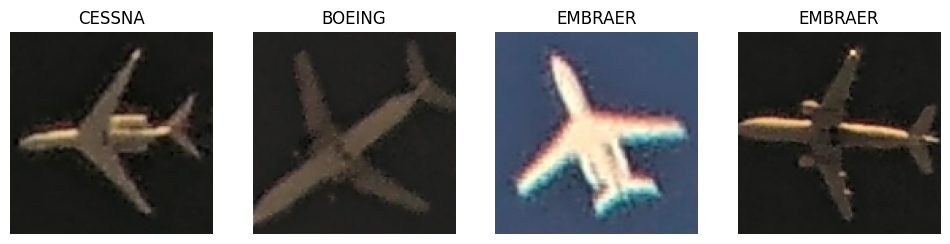

In [14]:
## by defaullt it will give the model batches of 64 for training and testing

## to view

dls.valid.show_batch(max_n=4, nrows=1)

## Example of padding the images

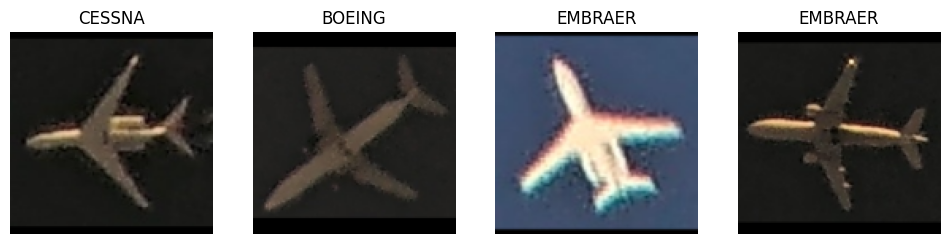

In [15]:
## instead of cropping

## we can pad the images

planes = planes.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = planes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)



## Squishing the images

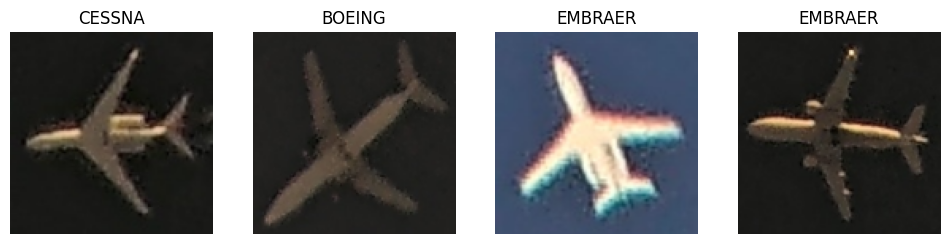

In [16]:
## or we can squish them

planes = planes.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = planes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

## Random cropping of an image is considered better

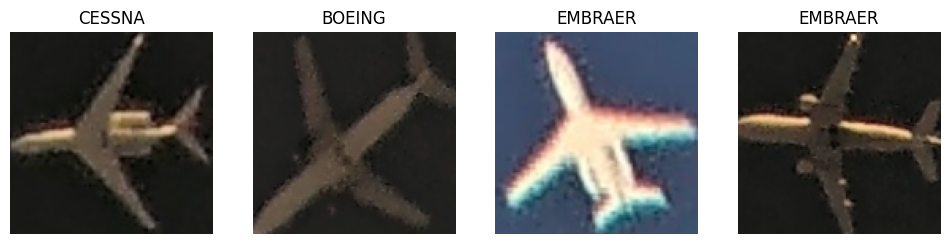

In [17]:
## random cropping of an image is considered better

planes = planes.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = planes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)



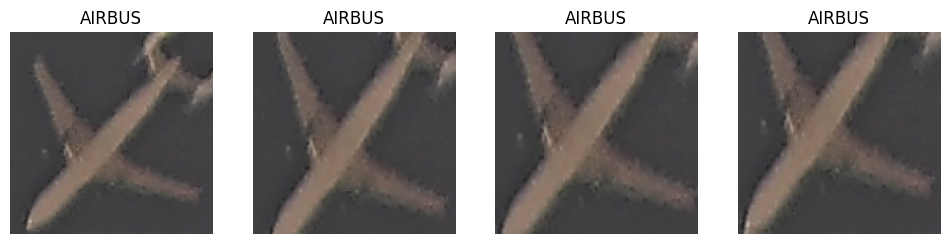

In [18]:
planes = planes.new(item_tfms=RandomResizedCrop(128, min_scale=0.5))
dls = planes.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

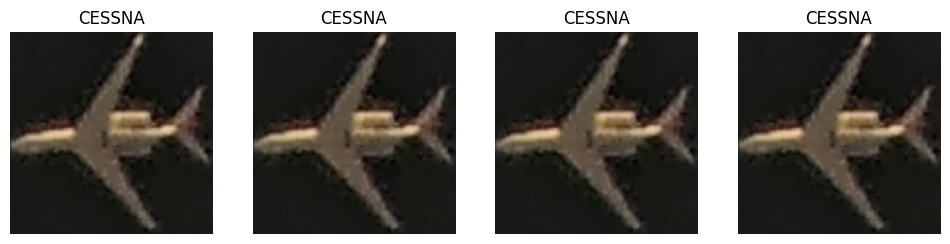

In [19]:
planes = planes.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = planes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

## Other data augmentation

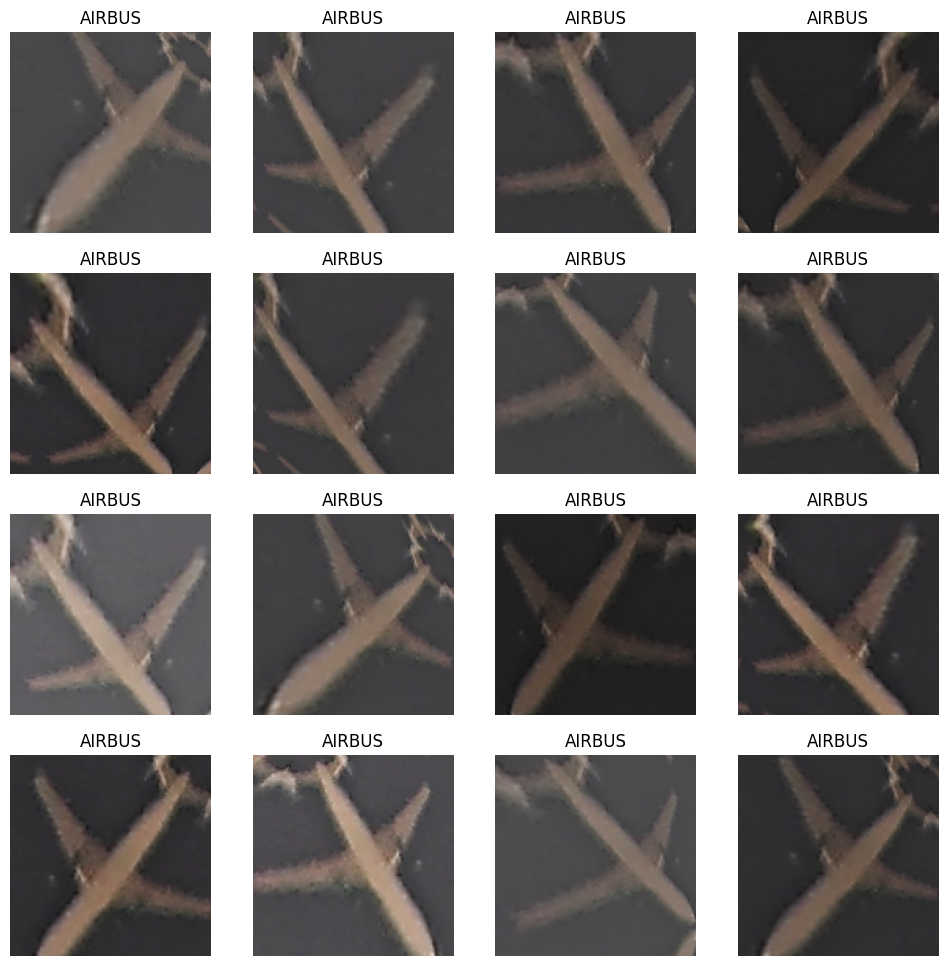

In [20]:
## data augmentation: rotation, flipping, perspective warping, contrast and brightness changes
## via GPU intensive batch_transforms

planes = planes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = planes.dataloaders(path)
dls.train.show_batch(max_n=16, nrows=4, unique=True)

## Fine Tune the pre-trained image classifier

Here we use a CNN learner based on ResNet18

CNN = Convolutional Neural Network

In [21]:
## now fine tune cnn_learner with our data

planes = planes.new(
     item_tfms=RandomResizedCrop(224, min_scale=0.5),
     batch_tfms=aug_transforms()
)

dls = planes.dataloaders(  path  )

learn = cnn_learner(dls, resnet18, metrics=error_rate)    ## metrics=batch_accuracy, metrics=accuracy

learn.fine_tune(4)

/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[W NNPACK.cpp:51] Could not

epoch,train_loss,valid_loss,error_rate,time
0,2.331731,1.216642,0.376465,09:40


epoch,train_loss,valid_loss,error_rate,time
0,1.228878,0.668888,0.215960,14:47
1,0.722482,0.504845,0.165464,14:53
2,0.472330,0.302950,0.105951,14:52
3,0.348771,0.280101,0.099188,14:56


## Confusion Matrix

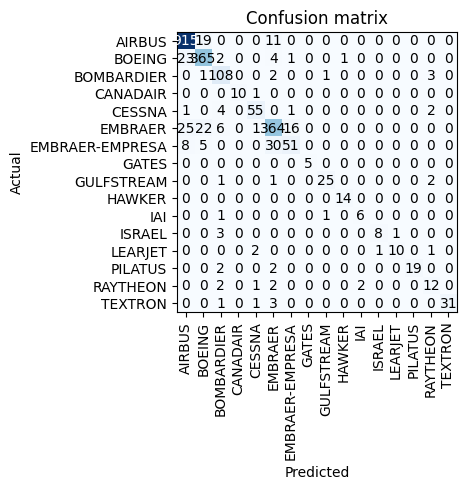

In [23]:

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()


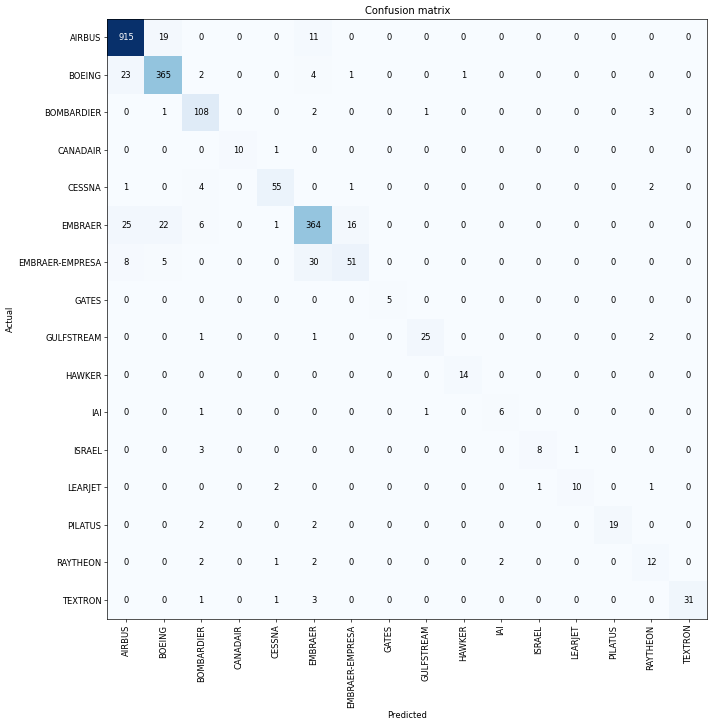

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## ML Performance Metrics

In [28]:

preds, y, losses = learn.get_preds(with_loss=True)


In [34]:

preds.shape


y_pred = torch.argmax(preds, dim=1)
y_pred.shape



torch.Size([2218])

In [35]:
y.shape

torch.Size([2218])

In [37]:

y_np       = y.numpy()
y_pred_np = y_pred.numpy()

accuracy = accuracy_score(y_np, y_pred_np)

f1 = f1_score(y_np, y_pred_np, average='weighted')

print(accuracy)
print(f1)



0.9008115419296664
0.8987498825045479


In [43]:

learn.dls.vocab


['AIRBUS', 'BOEING', 'BOMBARDIER', 'CANADAIR', 'CESSNA', 'EMBRAER', 'EMBRAER-EMPRESA', 'GATES', 'GULFSTREAM', 'HAWKER', 'IAI', 'ISRAEL', 'LEARJET', 'PILATUS', 'RAYTHEON', 'TEXTRON']

In [44]:


## target_names = ['class 0', 'class 1', 'class 2']
## print(classification_report(y_true, y_pred, target_names=target_names))

print(classification_report(y_np, y_pred_np))


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       945
           1       0.89      0.92      0.90       396
           2       0.83      0.94      0.88       115
           3       1.00      0.91      0.95        11
           4       0.90      0.87      0.89        63
           5       0.87      0.84      0.85       434
           6       0.74      0.54      0.63        94
           7       1.00      1.00      1.00         5
           8       0.93      0.86      0.89        29
           9       0.93      1.00      0.97        14
          10       0.75      0.75      0.75         8
          11       0.89      0.67      0.76        12
          12       0.91      0.71      0.80        14
          13       1.00      0.83      0.90        23
          14       0.60      0.63      0.62        19
          15       1.00      0.86      0.93        36

    accuracy                           0.90      2218
   macro avg       0.89   

In [46]:

print(classification_report(y_np, y_pred_np, target_names=learn.dls.vocab))


                 precision    recall  f1-score   support

         AIRBUS       0.94      0.97      0.95       945
         BOEING       0.89      0.92      0.90       396
     BOMBARDIER       0.83      0.94      0.88       115
       CANADAIR       1.00      0.91      0.95        11
         CESSNA       0.90      0.87      0.89        63
        EMBRAER       0.87      0.84      0.85       434
EMBRAER-EMPRESA       0.74      0.54      0.63        94
          GATES       1.00      1.00      1.00         5
     GULFSTREAM       0.93      0.86      0.89        29
         HAWKER       0.93      1.00      0.97        14
            IAI       0.75      0.75      0.75         8
         ISRAEL       0.89      0.67      0.76        12
        LEARJET       0.91      0.71      0.80        14
        PILATUS       1.00      0.83      0.90        23
       RAYTHEON       0.60      0.63      0.62        19
        TEXTRON       1.00      0.86      0.93        36

       accuracy              

## Plot some losses

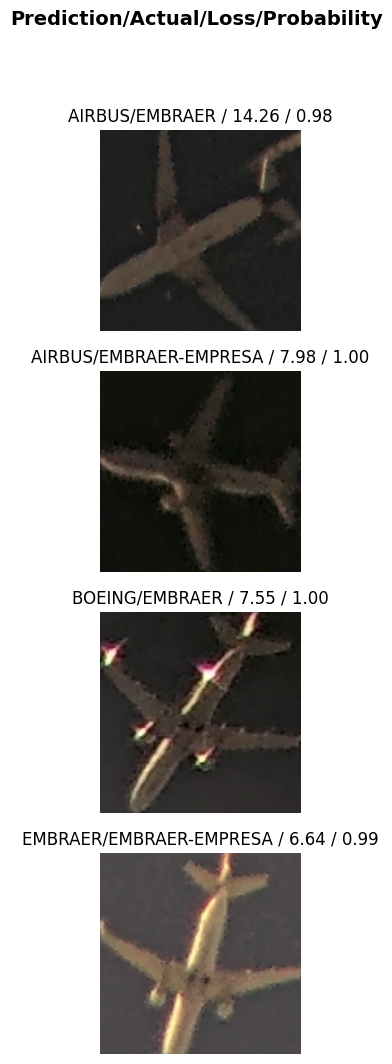

In [51]:
## plot_top_losses shows us the images with the highest loss in our dataset


interp.plot_top_losses(4, nrows=4)


In [53]:
## will save a export file called export.pkl to save the model


learn.export("SkyScanModel16Labels.pkl")


In [54]:
## load_model from file


learn_inf = load_learner('SkyScanModel16Labels.pkl')



In [56]:

img = 'CorpusSkyScan/AIRBUS/AA1219_2021-03-29-22-19-39.jpg'


is_plane, _, probs = learn.predict(img)
print(is_plane)
print(probs)


is_plane, _, probs = learn_inf.predict(img)
print(is_plane)
print(probs)



AIRBUS
TensorBase([    0.9998,     0.0000,     0.0000,     0.0000,     0.0000,
                0.0000,     0.0001,     0.0000,     0.0000,     0.0000,
                0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
                0.0000])


AIRBUS
TensorBase([    0.9998,     0.0000,     0.0000,     0.0000,     0.0000,
                0.0000,     0.0001,     0.0000,     0.0000,     0.0000,
                0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
                0.0000])


In [57]:
learn_inf.dls.vocab

['AIRBUS', 'BOEING', 'BOMBARDIER', 'CANADAIR', 'CESSNA', 'EMBRAER', 'EMBRAER-EMPRESA', 'GATES', 'GULFSTREAM', 'HAWKER', 'IAI', 'ISRAEL', 'LEARJET', 'PILATUS', 'RAYTHEON', 'TEXTRON']

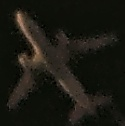

In [61]:

im = Image.open('CorpusSkyScan/AIRBUS/AA1219_2021-03-29-22-19-39.jpg')
im.thumbnail((256,256))
im


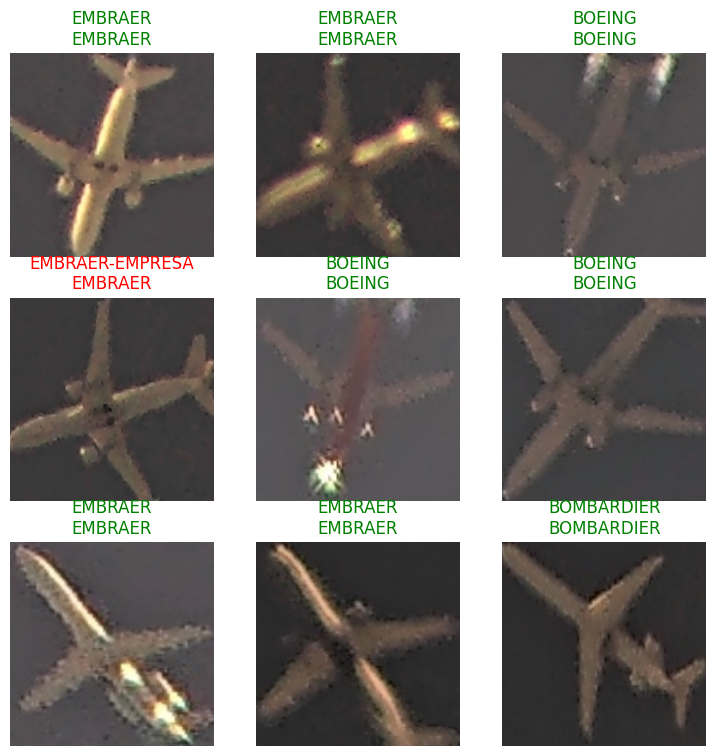

In [62]:
learn.show_results()

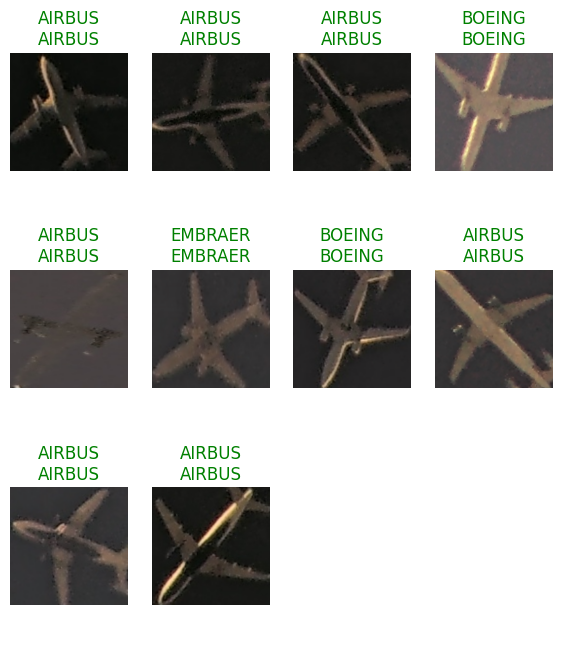

In [63]:
learn.show_results(max_n=10, figsize=(7, 8))